In [1]:
import math
import pandas as pd
import pyarrow
import fastparquet 


!pip3 install pyproj

import os
import configparser
import datetime as dt
from datetime import datetime
from os.path import exists
import time
from pytimeparse.timeparse import timeparse

import folium
from random import randint

import shapely
from shapely.geometry import Point, Polygon, LineString, GeometryCollection
from shapely.ops import nearest_points
from pyproj import Geod
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier
# To tune different models
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
rt_gtfs_data = pd.read_parquet('data/kh_transitview.parquet')
rt_gtfs_data = rt_gtfs_data.sort_values(by = ['file'])
rt_gtfs_data.head(5)

,BlockID,Direction,Offset,Offset_sec,VehicleID,destination,estimated_seat_availability,file,heading,label,lat,late,lng,next_stop_id,next_stop_name,next_stop_sequence,original_late,route,timestamp,trip
0,1081,SouthBound,1,10,8664,Frankford Transportation Center,NOT_AVAILABLE,2022-09-01,210,8664,40.093037,3,-75.017159,21945.0,Roosevelt Blvd & Plaza Dr - FS,71.0,3,14,2022-09-01 04:00:04+00:00,87728
128,5391,WestBound,1,7,7381,35th-Allegheny,NOT_AVAILABLE,2022-09-01,270,7381,40.001133,-2,-75.148354,20599.0,Allegheny Av & 5th St,27.0,-2,60,2022-09-01 04:00:04+00:00,75616
129,5436,NorthBound,1,27,7403,27th-Allegheny,NOT_AVAILABLE,2022-09-01,360,7403,39.978828,1,-75.182526,14942.0,29th St & Thompson St,44.0,2,48,2022-09-01 04:00:04+00:00,70324
130,5439,SouthBound,0,4,7412,Front-Market,NOT_AVAILABLE,2022-09-01,105,7412,39.949955,0,-75.142204,NaN,None,NaN,-2,48,2022-09-01 04:00:04+00:00,70182
131,5441,SouthBound,1,22,7319,Front-Market,NOT_AVAILABLE,2022-09-01,180,7319,39.989803,-1,-75.180038,30270.0,29th St & Huntingdon St,8.0,-1,48,2022-09-01 04:00:04+00:00,70183


In [3]:
rt_gtfs_data.dtypes

BlockID                                      int64
Direction                                   object
Offset                                       int64
Offset_sec                                   int64
VehicleID                                    int64
destination                                 object
estimated_seat_availability                 object
file                                datetime64[ns]
heading                                      int64
label                                        int64
lat                                        float64
late                                         int64
lng                                        float64
next_stop_id                               float64
next_stop_name                              object
next_stop_sequence                         float64
original_late                                int64
route                                       object
timestamp                      datetime64[ns, UTC]
trip                           

In [4]:
# Load Schedule Trips Data (trips_data)

In [5]:
sched_folder = '../../DSCI-591/sch_gtfs/schedule_v202209101'

In [6]:
trips_f = sched_folder + '/' + 'trips.txt'
trips_data = pd.read_csv(trips_f)
trips_data.head()

,route_id,service_id,trip_id,trip_headsign,block_id,direction_id,shape_id
0,1,10,87152,Decatur-Drummond,1003,0,275147
1,1,10,87153,Parx Casino,2151,0,275145
2,1,10,87154,Parx Casino via Decatur-Drummond,2155,0,275152
3,1,10,87155,Decatur-Drummond,1426,0,275151
4,1,10,87156,Parx Casino via Decatur-Drummond,2153,0,275152


In [7]:
# Load Schedule Shapes Data (shapes_data)

In [8]:
shapes_f = sched_folder + '/' + 'shapes.txt'
shapes_data = pd.read_csv(shapes_f)
shapes_data.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
0,275145,40.105486,-75.000047,1072
1,275145,40.110772,-74.992364,1097
2,275145,40.112407,-74.989999,1104
3,275145,40.052940,-75.049911,953
4,275145,40.011494,-75.200398,467


In [9]:
# Load Schedule stops Data (stops_data)

In [10]:
stops_f = sched_folder + '/' + 'stop_times.txt'
stops_data = pd.read_csv(stops_f)
stops_data.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence
0,33584,07:14:00,07:14:00,31294,1
1,33584,07:14:00,07:14:00,20610,2
2,33584,07:15:00,07:15:00,20611,3
3,33584,07:16:00,07:16:00,20612,4
4,33584,07:18:00,07:18:00,20613,5


In [11]:
###############################################################################
###############################################################################
###############################################################################

In [12]:
# Function to return schedule start/end times and first/last stop_ids of a trip_id
def get_sched_stop_times(trip_id):
    
    data = stops_data.loc[stops_data['trip_id'] == trip_id]
    
    if not data.empty:
        data = data.sort_values(by=['stop_sequence'])
        data1 = data.iloc[0]
        data2 = data.iloc[-1]
    
        return [data1['departure_time'], data1['stop_id'], data1['stop_sequence'],\
                data2['arrival_time'], data2['stop_id'], data2['stop_sequence']]
    
    else:
        return ['NA']

In [13]:
# Function to return schedule shape of a shape_id
def get_sched_shape(shape_id):
    
    data = shapes_data.loc[shapes_data['shape_id'] == shape_id]
    data = data.sort_values(by=['shape_pt_sequence'])
    data = list(zip(data.shape_pt_lat, data.shape_pt_lon))
    
    if len(data) > 1:
        return data
    else:
        return ['NA']

In [14]:
# Function to return schedule route_id, trip_id, shape_id, shapes for a given route list
def get_sched_route_gtfs(routes):

    data = pd.DataFrame(columns=['route_id', 'trip_id', 'sch_shape_id', 'sch_dep_time', 'sch_first_stop_id',
                                 'sch_first_stop_seq', 'sch_arr_time','sch_last_stop_id', 'sch_last_stop_seq',
                                 'sch_shape', 'rt_shape'])
    
    i = 0 #output DF index
    
    for route_id in routes:
        # for route, get all trips and keep needed columns
        trip = trips_data.loc[trips_data['route_id'] == route_id]
        trip = trip[['route_id', 'trip_id', 'shape_id']]

        # iterate over trips
        for index, row in trip.iterrows():
            # get trip stop and shape information
            stops = get_sched_stop_times(row['trip_id'])
            sched_shape = get_sched_shape(row['shape_id'])
            
            # if stop and shape info found add trip to output
            if stops[0] != 'NA' and sched_shape[0] != 'NA':
                
                data.at[i, 'route_id'] = row['route_id']
                data.at[i, 'trip_id'] = row['trip_id']
                data.at[i, 'sch_shape_id'] = row['shape_id']
                data.at[i, 'sch_dep_time'] = stops[0]
                data.at[i, 'sch_first_stop_id'] = stops[1]
                data.at[i, 'sch_first_stop_seq'] = stops[2]
                data.at[i, 'sch_arr_time'] = stops[3]
                data.at[i, 'sch_last_stop_id'] = stops[4]
                data.at[i, 'sch_last_stop_seq'] = stops[5]
                
                data.at[i, 'sch_shape'] = sched_shape
                
                i += 1
                
    data = data.astype({"route_id":'str', "trip_id":'Int64', "sch_shape_id":'Int64', "sch_dep_time":'str',
                        "sch_first_stop_id":'Int64', "sch_first_stop_seq":'Int64', "sch_arr_time":'str',
                        "sch_last_stop_id":'Int64', "sch_last_stop_seq":'Int64'}) 
        
    return data

In [15]:
def get_rt_shape(data):

    shape = data.sort_values(by = ['file'])
    shape = list(zip(shape.lat, shape.lng))
    
    # only return RT shapes that have more than 1 point
    if len(shape) > 1:
        return shape
    else:
        return 'NA'

In [16]:
def get_rt_gtfs(trip_id, sched_dep_dt, sched_first_stop_id, sched_arr_dt, sch_last_stop_id):
    
    # WILL EXCLUDE ALL TRIPS THAT DON'T START AT SCHEDULED STOP ID
    
    # look for RT data starting 5 minutes before sched departure, and arriving max 3 hours after sched arrival
    minus_delta = dt.timedelta(minutes=5)
    plus_delta = dt.timedelta(hours=3)
    
    data = rt_gtfs_data.loc[(rt_gtfs_data['file'] >= sched_dep_dt - minus_delta) & (rt_gtfs_data['file'] <= sched_arr_dt + plus_delta) &\
                            (rt_gtfs_data['trip'] == trip_id)]
    # exclude RT trips that have only 1 coordinate 
    if len(data.index) >= 2:
        data = data.sort_values(by=['file'])
        
        # drop all early feed updates where next stop id = sched_first_stop_id, except last one
        # this should eliminate feed updates before trip starts
        prev_index = -9        
        for index, row in data.iterrows():
            if row['next_stop_id'] == sched_first_stop_id and prev_index == -9:
                prev_index = index
            elif row['next_stop_id'] == sched_first_stop_id and prev_index != -9:
                data = data.drop([prev_index])
                prev_index = index
            else:
                break
                
        # if route still has more than 1 coordinate
        if len(data.index) >= 2:
            # keep only one feed update after last stop where next stop id is NaN
            # this should drop feed updates after bus arrives at last scheduled stop
            for index, row in data.iterrows():
                if row['next_stop_id'] == sch_last_stop_id:
                    if len(data.index) > index + 1:
                        if math.isnan(data.iloc[index+1]['next_stop_id']):
                            data = data.loc[:index+1]
            
#            while (math.isnan(data.iloc[-1]['next_stop_id'])):
#                if math.isnan(data.iloc[-2]['next_stop_id']):
#                    data = data[:-1]
#                else:
#                    break

            # if more than 1 coordinate in trip remains then
            if len(data.index) >= 2:
                # take first and before last feed updates to get first/last dep/arr info
                data1 = data.iloc[0] 
                data2 = data.iloc[-2]

                # get the RT shape
                rt_shape = get_rt_shape(data)

                if rt_shape != 'NA':
                    return[data1['Direction'], data1['VehicleID'], data1['file'], data1['next_stop_id'], data1['next_stop_sequence'],
                                                                   data2['file'], data2['next_stop_id'], data2['next_stop_sequence'], rt_shape]
                else:
                    return['NA']
            else:
                return['NA']
        else:
            return['NA']
    else:
        return['NA']  

In [17]:
def make_dataset(routes, dates):
    
    data = get_sched_route_gtfs(routes) 
    
    out_data = pd.DataFrame()
    
    # get date at start and of search window
    from_dt = datetime.strptime(dates[0], '%m/%d/%Y %H:%M')
    from_day = from_dt.date()
    to_dt = datetime.strptime(dates[1], '%m/%d/%Y %H:%M')
    to_day = to_dt.date()
    day_delta = dt.timedelta(days=1)
    
    # add columns to sched GTFS DF
    data = data.assign(rt_direction = np.nan,
                       rt_vehicle_id = np.nan,
                       rt_dep_time = np.nan,
                       rt_first_stop_id = np.nan,
                       rt_first_stop_seq = np.nan,
                       rt_arr_time = np.nan,
                       rt_last_stop_id = np.nan,
                       rt_last_stop_seq = np.nan,
                      )
    
    #get trips on each day between from_day -> to_day
    while (from_day <= to_day):
        
        # making a copy bec same trip id may exist on multiple dates being retrieved 
        day_data = data.copy()
        
        # for each trip_id on this day
        for index, row in day_data.iterrows():
            
            # create datetime of scheduled departure and arrival
            sched_dep_dt = datetime.combine(from_day, dt.time.min) + dt.timedelta(seconds = timeparse(row['sch_dep_time']))
            sched_arr_dt = datetime.combine(from_day, dt.time.min) + dt.timedelta(seconds = timeparse(row['sch_arr_time']))  
            
            # if trip is scheduled between requested datetimes
            if sched_dep_dt >= from_dt and sched_dep_dt <= to_dt:
                
                rt_data = get_rt_gtfs(row['trip_id'], sched_dep_dt, row['sch_first_stop_id'], sched_arr_dt, row['sch_last_stop_id'])
                
                # if RT gtfs data found for this day
                if rt_data[0] != 'NA': 
                    day_data.at[index, 'rt_direction'] = rt_data[0]
                    day_data.at[index, 'rt_vehicle_id'] = rt_data[1]
                    day_data.at[index, 'sch_dep_time'] = sched_dep_dt
                    day_data.at[index, 'sch_arr_time'] = sched_arr_dt
                    day_data.at[index, 'rt_dep_time'] = rt_data[2]
                    day_data.at[index, 'rt_first_stop_id'] = rt_data[3]
                    day_data.at[index, 'rt_first_stop_seq'] = rt_data[4]
                    day_data.at[index, 'rt_arr_time'] = rt_data[5]
                    day_data.at[index, 'rt_last_stop_id'] = rt_data[6]
                    day_data.at[index, 'rt_last_stop_seq'] = rt_data[7]
                    day_data.at[index, 'rt_shape'] = rt_data[8]
                
                # if no RT gtfs found for this day drop today's trip 
                else:
                    day_data = day_data.drop([index])
            # if scheduled trip departure time out of window drop today's trip     
            else:
                day_data = day_data.drop([index])
                
        out_data = pd.concat([out_data, day_data])
        
        from_day += day_delta
    
    # set data types
    out_data = out_data.astype({"route_id":'str', "trip_id":'Int64', "sch_shape_id":'Int64', "rt_direction":'str', "rt_vehicle_id":'Int64',
                                "sch_dep_time":'datetime64[ns]', "sch_first_stop_id":'Int64', "sch_first_stop_seq":'Int64',
                                "sch_arr_time":'datetime64[ns]', "sch_last_stop_id":'Int64', "sch_last_stop_seq":'Int64',
                                "rt_dep_time":'datetime64[ns]', "rt_first_stop_id":'Int64', "rt_first_stop_seq":'Int64',
                                "rt_arr_time":'datetime64[ns]', "rt_last_stop_id":'Int64', "rt_last_stop_seq":'Int64'}) 
    
    # reorder columns
    out_data = out_data[['route_id', 'trip_id', 'sch_shape_id', 'rt_direction', 'rt_vehicle_id', 'sch_dep_time', 'sch_first_stop_id',
                         'sch_first_stop_seq', 'sch_arr_time', 'sch_last_stop_id', 'sch_last_stop_seq', 'rt_dep_time', 'rt_first_stop_id',
                         'rt_first_stop_seq', 'rt_arr_time', 'rt_last_stop_id', 'rt_last_stop_seq', 'sch_shape', 'rt_shape']]
    
    
    out_data['sch_shape_len'] = [len(shape) for shape in out_data['sch_shape']]
    out_data['rt_shape_len'] = [len(shape) for shape in out_data['rt_shape']]

    out_data['sch_trip_len'] = [LineString(shape).length for shape in out_data['sch_shape']]
    out_data['rt_trip_len'] = [LineString(shape).length for shape in out_data['rt_shape']]
       
    
    
    # reset the DF index
    out_data = out_data.reset_index(drop = True)
    
    return out_data 

In [19]:
# PREPARE SCHEDULE + RT GTFS INTEGRATED DATASET

#routes = list(rt_gtfs_data.route.unique())
routes = ['57', '73', '92', '60', '79', '10', '16']
start_between = ['9/01/2022 00:00', '9/30/2022 23:59']

data_set = make_dataset(routes, start_between) 

data_set.head()

,route_id,trip_id,sch_shape_id,rt_direction,rt_vehicle_id,sch_dep_time,sch_first_stop_id,sch_first_stop_seq,sch_arr_time,sch_last_stop_id,...,rt_first_stop_seq,rt_arr_time,rt_last_stop_id,rt_last_stop_seq,sch_shape,rt_shape,sch_shape_len,rt_shape_len,sch_trip_len,rt_trip_len
0,57,73834,275580,SouthBound,8543,2022-09-01 08:05:00,841,1,2022-09-01 09:16:00,99,...,2,2022-09-01 09:27:00,<NA>,<NA>,"[(40.041995, -75.136952), (40.04353, -75.13665...","[(40.046013, -75.135872), (40.045902, -75.1313...",439,82,0.203646,0.193281
1,57,73835,275580,SouthBound,8449,2022-09-01 08:25:00,841,1,2022-09-01 09:36:00,99,...,<NA>,2022-09-01 09:46:00,<NA>,<NA>,"[(40.041995, -75.136952), (40.04353, -75.13665...","[(39.983368, -75.17320999999998), (39.938431, ...",439,76,0.203646,0.404865
2,57,73836,275578,SouthBound,8030,2022-09-01 08:30:00,844,33,2022-09-01 09:26:00,99,...,33,2022-09-01 09:34:00,18130,121,"[(40.034178, -75.115393), (40.03376, -75.11549...","[(40.028992, -75.11955299999998), (40.027699, ...",301,58,0.142237,0.132476
3,57,73837,275580,SouthBound,8012,2022-09-01 08:46:00,841,1,2022-09-01 09:56:00,99,...,1,2022-09-01 09:56:00,18130,121,"[(40.041995, -75.136952), (40.04353, -75.13665...","[(40.046097, -75.135841), (40.045986, -75.1322...",439,70,0.203646,0.198939
4,57,73838,275578,SouthBound,3339,2022-09-01 09:10:00,844,33,2022-09-01 10:06:00,99,...,<NA>,2022-09-01 10:18:00,<NA>,<NA>,"[(40.034178, -75.115393), (40.03376, -75.11549...","[(40.034382, -75.11557), (40.034409, -75.11557...",301,68,0.142237,0.140262


In [20]:
data_set

,route_id,trip_id,sch_shape_id,rt_direction,rt_vehicle_id,sch_dep_time,sch_first_stop_id,sch_first_stop_seq,sch_arr_time,sch_last_stop_id,...,rt_first_stop_seq,rt_arr_time,rt_last_stop_id,rt_last_stop_seq,sch_shape,rt_shape,sch_shape_len,rt_shape_len,sch_trip_len,rt_trip_len
0,57,73834,275580,SouthBound,8543,2022-09-01 08:05:00,841,1,2022-09-01 09:16:00,99,...,2,2022-09-01 09:27:00,<NA>,<NA>,"[(40.041995, -75.136952), (40.04353, -75.13665...","[(40.046013, -75.135872), (40.045902, -75.1313...",439,82,0.203646,0.193281
1,57,73835,275580,SouthBound,8449,2022-09-01 08:25:00,841,1,2022-09-01 09:36:00,99,...,<NA>,2022-09-01 09:46:00,<NA>,<NA>,"[(40.041995, -75.136952), (40.04353, -75.13665...","[(39.983368, -75.17320999999998), (39.938431, ...",439,76,0.203646,0.404865
2,57,73836,275578,SouthBound,8030,2022-09-01 08:30:00,844,33,2022-09-01 09:26:00,99,...,33,2022-09-01 09:34:00,18130,121,"[(40.034178, -75.115393), (40.03376, -75.11549...","[(40.028992, -75.11955299999998), (40.027699, ...",301,58,0.142237,0.132476
3,57,73837,275580,SouthBound,8012,2022-09-01 08:46:00,841,1,2022-09-01 09:56:00,99,...,1,2022-09-01 09:56:00,18130,121,"[(40.041995, -75.136952), (40.04353, -75.13665...","[(40.046097, -75.135841), (40.045986, -75.1322...",439,70,0.203646,0.198939
4,57,73838,275578,SouthBound,3339,2022-09-01 09:10:00,844,33,2022-09-01 10:06:00,99,...,<NA>,2022-09-01 10:18:00,<NA>,<NA>,"[(40.034178, -75.115393), (40.03376, -75.11549...","[(40.034382, -75.11557), (40.034409, -75.11557...",301,68,0.142237,0.140262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3817,16,58872,275202,NorthBound,3339,2022-09-05 15:05:00,515,1,2022-09-05 15:59:00,136,...,1,2022-09-05 16:35:00,<NA>,<NA>,"[(39.952743, -75.16525), (39.952605, -75.16528...","[(39.950947, -75.164032), (39.951191, -75.1637...",511,82,0.143045,0.231361
3818,16,58873,275202,NorthBound,3341,2022-09-05 06:14:00,515,1,2022-09-05 06:55:00,136,...,1,2022-09-05 07:15:00,<NA>,<NA>,"[(39.952743, -75.16525), (39.952605, -75.16528...","[(39.951988, -75.16265099999998), (39.956005, ...",511,56,0.143045,0.135095
3819,16,58874,275202,NorthBound,8264,2022-09-05 06:40:00,515,1,2022-09-05 07:22:00,136,...,2,2022-09-05 07:37:00,<NA>,<NA>,"[(39.952743, -75.16525), (39.952605, -75.16528...","[(39.955318, -75.162788), (39.957546, -75.1623...",511,55,0.143045,0.132739
3820,16,58875,275202,NorthBound,8279,2022-09-05 07:39:00,515,1,2022-09-05 08:24:00,136,...,1,2022-09-05 08:30:00,17344,81,"[(39.952743, -75.16525), (39.952605, -75.16528...","[(39.951084, -75.16552699999998), (39.951496, ...",511,47,0.143045,0.136947


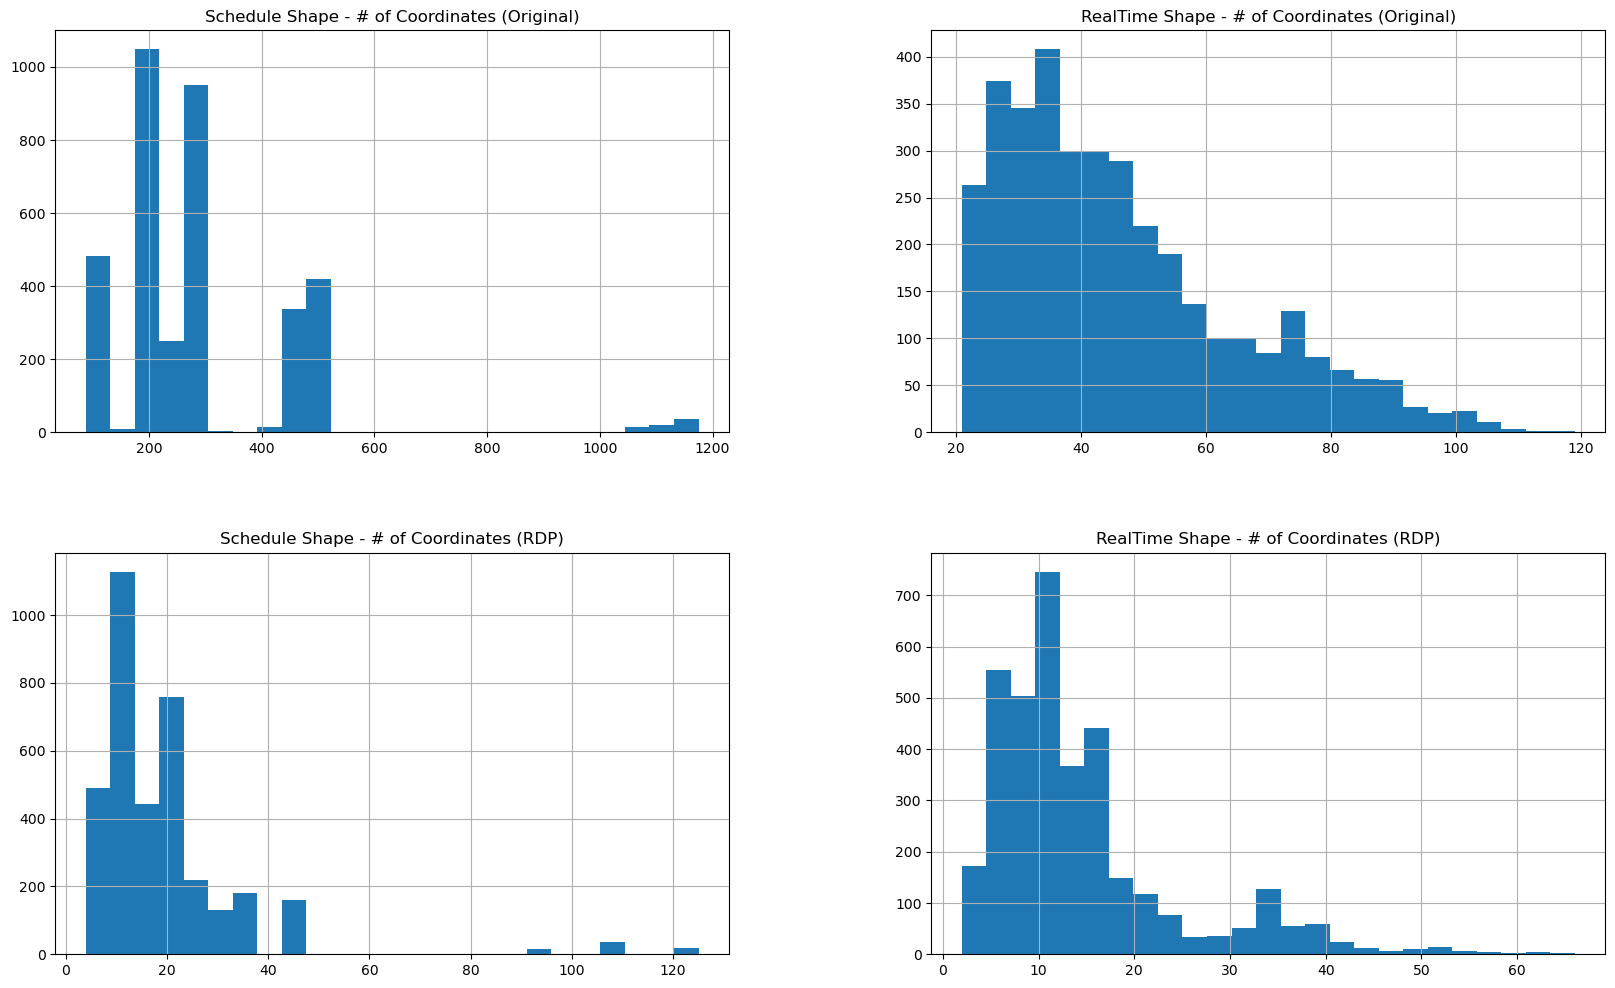

In [21]:
from rdp import rdp
data_set_cln = data_set.copy()

data_set_cln = data_set_cln[data_set_cln['rt_shape_len'] > 20]

for idx, row in data_set_cln.iterrows():
    trip_len_ratio = row['rt_trip_len']/row['sch_trip_len']
    if trip_len_ratio > 1.25 or trip_len_ratio < 0.75:
        data_set_cln.drop([idx])

data_set_cln.to_parquet('data\data_set_cln.parquet', compression='gzip')


data_set_rdp = data_set_cln.copy()

data_set_rdp['rdp_sch_shape'] = [rdp(shape, epsilon=0.0001) for shape in data_set_rdp['sch_shape']]
data_set_rdp['rdp_rt_shape'] = [rdp(shape, epsilon=0.0001) for shape in data_set_rdp['rt_shape']]

data_set_rdp['rdp_sch_shape_len'] = [len(shape) for shape in data_set_rdp['rdp_sch_shape']]
data_set_rdp['rdp_rt_shape_len'] = [len(shape) for shape in data_set_rdp['rdp_rt_shape']]

data_set_rdp.to_parquet('data\data_set_rdp.parquet', compression='gzip')

shape_len_hist = pd.DataFrame()
shape_len_hist["Schedule Shape - # of Coordinates (Original)"] = data_set_rdp['sch_shape_len']
shape_len_hist["RealTime Shape - # of Coordinates (Original)"] = data_set_rdp['rt_shape_len']
shape_len_hist["Schedule Shape - # of Coordinates (RDP)"] = data_set_rdp['rdp_sch_shape_len']
shape_len_hist["RealTime Shape - # of Coordinates (RDP)"] = data_set_rdp['rdp_rt_shape_len']
x= shape_len_hist.hist(bins=25, figsize=(20,12))


In [24]:
import similaritymeasures
data_set_sim = data_set_rdp.copy()

for idx, row in data_set_sim.iterrows():
    
    sch_ln = LineString(row['rdp_sch_shape'])
    rt_ln = LineString(row['rdp_rt_shape'])
    
    data_set_sim.at[idx, 'Hausdorff_Dist'] = rt_ln.hausdorff_distance(sch_ln)
    
    rt = np.stack(row['rdp_rt_shape'], axis=0)
    sh = np.stack(row['rdp_sch_shape'], axis=0)
    
    data_set_sim.at[idx, 'PCM'] = similaritymeasures.pcm(rt, sh)
    data_set_sim.at[idx, 'Frechet_Dist'] = similaritymeasures.frechet_dist(rt, sh)
    data_set_sim.at[idx, 'Area_bt_Curves'] = similaritymeasures.area_between_two_curves(rt, sh)
    data_set_sim.at[idx, 'Curve_length'] = similaritymeasures.curve_length_measure(rt, sh)
#    data_set_sim.at[idx, 'Dynamic_Time_Warp'] = similaritymeasures.dtw(rt, sh)
#    data_set_sim.at[idx, 'Mean_Abs_Error'] = similaritymeasures.mae(rt, sh)
#    data_set_sim.at[idx, 'Mean_Sq_Error'] = similaritymeasures.mse(rt, sh)

data_set_sim.to_parquet('data\data_set_sim.parquet', compression='gzip')

data_set_sim.head()

,route_id,trip_id,sch_shape_id,rt_direction,rt_vehicle_id,sch_dep_time,sch_first_stop_id,sch_first_stop_seq,sch_arr_time,sch_last_stop_id,...,rt_trip_len,rdp_sch_shape,rdp_rt_shape,rdp_sch_shape_len,rdp_rt_shape_len,Hausdorff_Dist,PCM,Frechet_Dist,Area_bt_Curves,Curve_length
0,57,73834,275580,SouthBound,8543,2022-09-01 08:05:00,841,1,2022-09-01 09:16:00,99,...,0.193281,"[[40.041995, -75.136952], [40.046157, -75.1360...","[[40.046013, -75.135872], [40.045902, -75.1313...",47,34,0.010856,1.240727,0.013214,0.000495,0.000619
1,57,73835,275580,SouthBound,8449,2022-09-01 08:25:00,841,1,2022-09-01 09:36:00,99,...,0.404865,"[[40.041995, -75.136952], [40.046157, -75.1360...","[[39.983368, -75.17320999999998], [39.938431, ...",47,33,0.056798,7.621422,0.088400,0.008403,0.014871
2,57,73836,275578,SouthBound,8030,2022-09-01 08:30:00,844,33,2022-09-01 09:26:00,99,...,0.132476,"[[40.034178, -75.115393], [40.03376, -75.11549...","[[40.028992, -75.11955299999998], [40.021729, ...",33,21,0.006648,1.386850,0.016082,0.000363,0.000383
3,57,73837,275580,SouthBound,8012,2022-09-01 08:46:00,841,1,2022-09-01 09:56:00,99,...,0.198939,"[[40.041995, -75.136952], [40.046157, -75.1360...","[[40.046097, -75.135841], [40.045986, -75.1322...",47,33,0.009351,1.059076,0.009928,0.000462,0.000675
4,57,73838,275578,SouthBound,3339,2022-09-01 09:10:00,844,33,2022-09-01 10:06:00,99,...,0.140262,"[[40.034178, -75.115393], [40.03376, -75.11549...","[[40.034382, -75.11557], [40.034187, -75.11521...",33,22,0.010036,0.947032,0.017097,0.000545,0.000379


In [25]:
data_set_sim.sch_shape_id.value_counts()

274383    428
274388    403
275764    245
275632    239
275639    231
275766    228
275748    213
275199    210
275202    203
275752    200
275598    157
275580    155
275578    127
275635    117
275646    115
275597    111
275750     25
274760     19
274762     18
274763     18
274761     15
275595     14
275754     12
275592     10
275640     10
275200      9
275634      5
275581      5
274387      4
275579      4
275647      4
275577      4
275594      4
275633      2
275642      2
275643      2
275644      2
275582      2
275583      2
275645      1
275765      1
275763      1
275749      1
275586      1
Name: sch_shape_id, dtype: Int64

In [27]:
final_dset = data_set_sim.loc[data_set_sim['sch_shape_id'] == 274383]
final_dset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 669 to 3691
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   route_id            428 non-null    object        
 1   trip_id             428 non-null    Int64         
 2   sch_shape_id        428 non-null    Int64         
 3   rt_direction        428 non-null    object        
 4   rt_vehicle_id       428 non-null    Int64         
 5   sch_dep_time        428 non-null    datetime64[ns]
 6   sch_first_stop_id   428 non-null    Int64         
 7   sch_first_stop_seq  428 non-null    Int64         
 8   sch_arr_time        428 non-null    datetime64[ns]
 9   sch_last_stop_id    428 non-null    Int64         
 10  sch_last_stop_seq   428 non-null    Int64         
 11  rt_dep_time         428 non-null    datetime64[ns]
 12  rt_first_stop_id    423 non-null    Int64         
 13  rt_first_stop_seq   423 non-null    Int64      

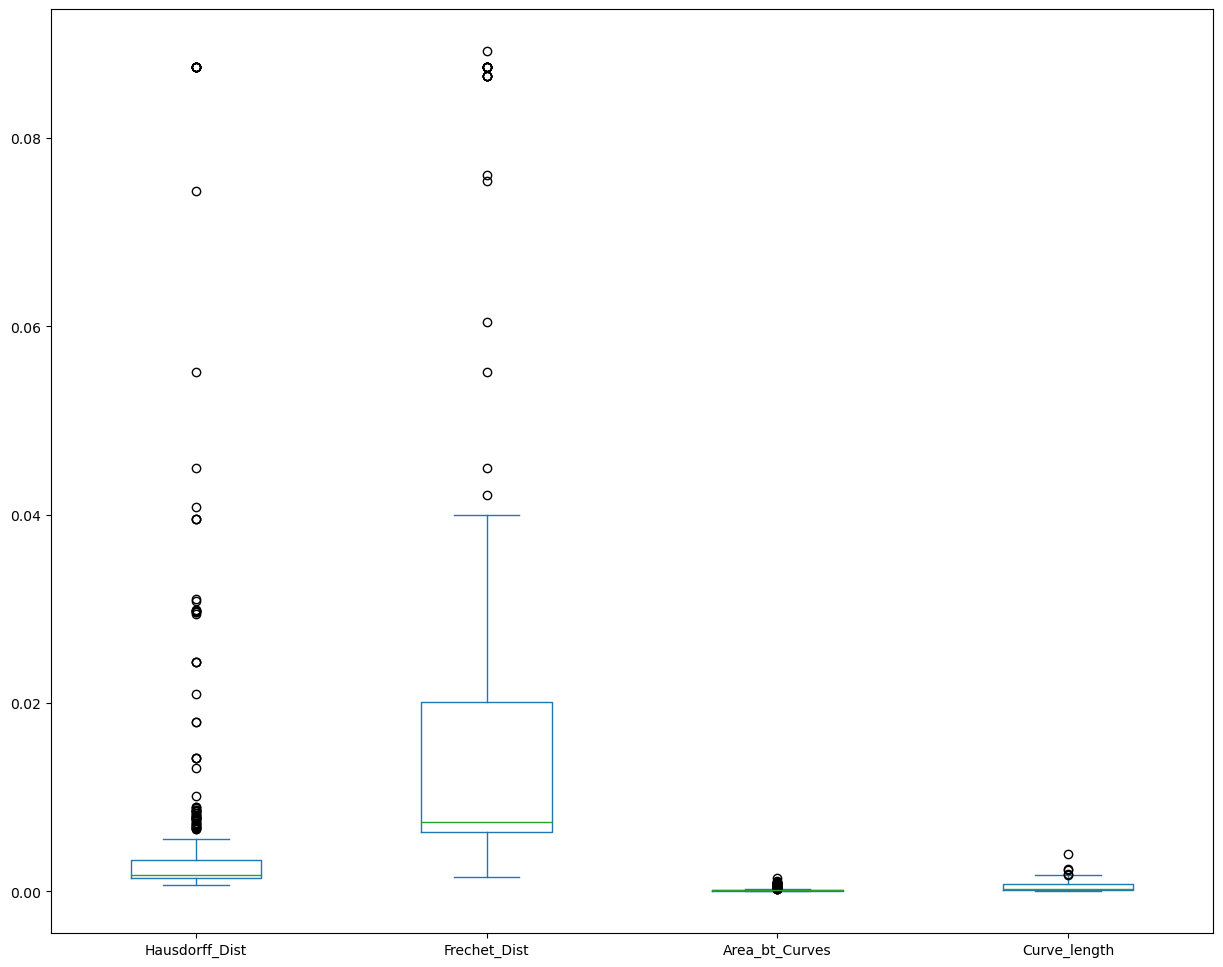

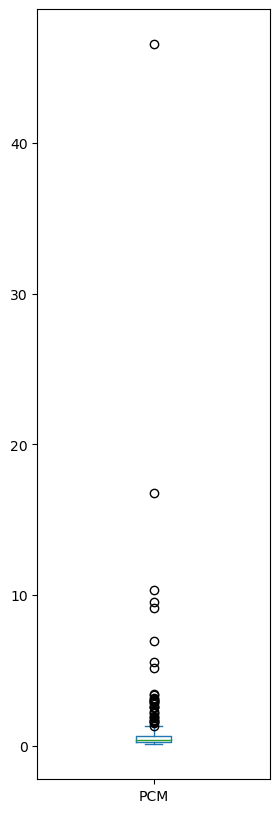

In [28]:
x= final_dset[['Hausdorff_Dist', 'Frechet_Dist', 'Area_bt_Curves', 'Curve_length']].plot.box(figsize=(15,12))
x= final_dset[['PCM']].plot.box(figsize=(3,10))

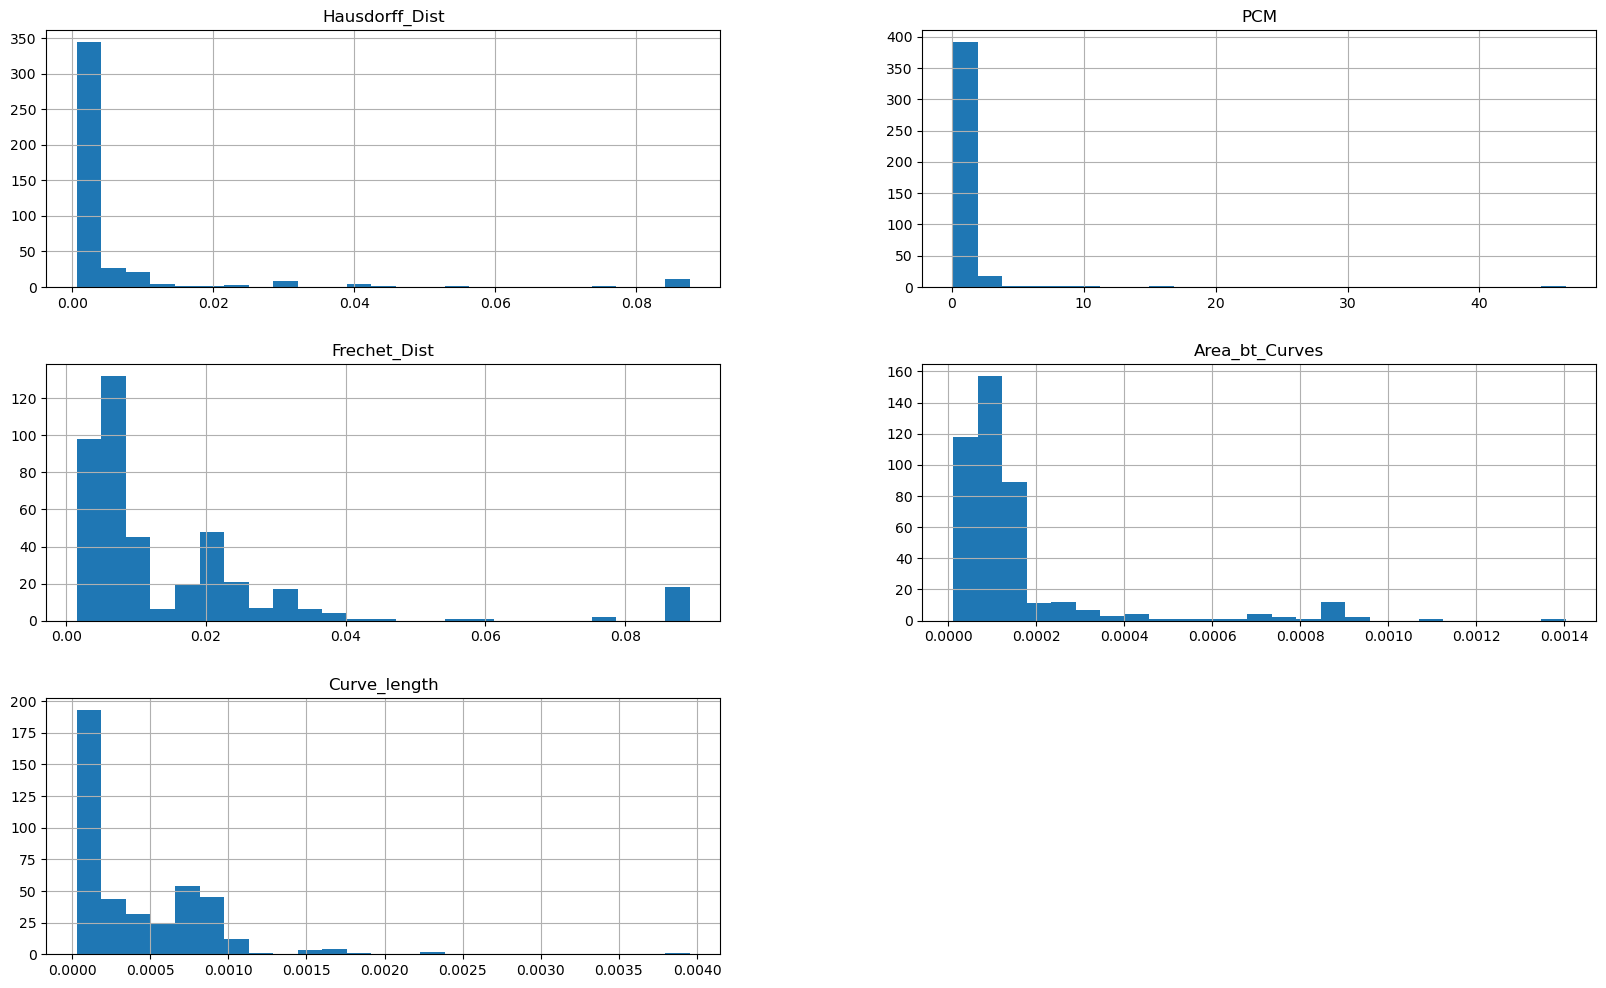

In [29]:
x = final_dset[['Hausdorff_Dist', 'PCM', 'Frechet_Dist', 'Area_bt_Curves', 'Curve_length']].hist(bins=25, figsize=(20,12))

# x = data_set_sim[['Hausdorff_Dist', 'PCM', 'Frechet_Dist', 'Area_bt_Curves', 'Curve_length']].hist(bins=25, figsize=(20,12))

In [54]:
map = folium.Map(location=[40,-75.154839], zoom_start= 12) 
folium.PolyLine(final_dset_no['rt_shape'], color = 'blue', popup = 'Schedule shape', weight=2, opacity=0.6).add_to(map)
folium.PolyLine(final_dset_an['rt_shape'], color = 'red', popup = 'Schedule shape', weight=2, opacity=0.6).add_to(map) 
# folium.PolyLine(final_dset.iloc[index_to_plot]['rt_shape'], color = 'red', popup = 'RT shape', weight=7, opacity=0.6).add_to(map) 
map

In [30]:
final_dset_01 = final_dset[['trip_id', 'rdp_sch_shape_len', 'rdp_rt_shape_len', 'Hausdorff_Dist', 'Frechet_Dist', 'Area_bt_Curves', 'Curve_length']]
final_dset_01

,trip_id,rdp_sch_shape_len,rdp_rt_shape_len,Hausdorff_Dist,Frechet_Dist,Area_bt_Curves,Curve_length
669,33584,18,18,0.001623,0.003368,0.000011,0.000112
670,33585,18,18,0.001256,0.022034,0.000119,0.000892
671,33586,18,13,0.001642,0.004442,0.000044,0.000104
672,33587,18,9,0.013107,0.013107,0.000223,0.000528
673,33588,18,17,0.001055,0.008407,0.000723,0.000582
...,...,...,...,...,...,...,...
3687,34627,18,12,0.002746,0.006333,0.000093,0.000148
3688,34628,18,13,0.002161,0.003756,0.000092,0.000114
3689,34629,18,9,0.003083,0.006826,0.000105,0.000166
3690,34630,18,17,0.001701,0.010140,0.000035,0.000127


In [31]:
final_dset_02 = final_dset_01.dropna()
final_dset_02

,trip_id,rdp_sch_shape_len,rdp_rt_shape_len,Hausdorff_Dist,Frechet_Dist,Area_bt_Curves,Curve_length
669,33584,18,18,0.001623,0.003368,0.000011,0.000112
670,33585,18,18,0.001256,0.022034,0.000119,0.000892
671,33586,18,13,0.001642,0.004442,0.000044,0.000104
672,33587,18,9,0.013107,0.013107,0.000223,0.000528
673,33588,18,17,0.001055,0.008407,0.000723,0.000582
...,...,...,...,...,...,...,...
3687,34627,18,12,0.002746,0.006333,0.000093,0.000148
3688,34628,18,13,0.002161,0.003756,0.000092,0.000114
3689,34629,18,9,0.003083,0.006826,0.000105,0.000166
3690,34630,18,17,0.001701,0.010140,0.000035,0.000127


In [32]:
Final_Data = final_dset_02

Final_Data.loc[Final_Data['Frechet_Dist'] >= 0.025, "Anomaly"] = 1
Final_Data.loc[Final_Data['Frechet_Dist'] < 0.025, "Anomaly"] = 0


Final_Data = Final_Data.drop(columns='Frechet_Dist')
Final_Data = Final_Data.drop(columns='trip_id')
Final_Data = Final_Data.astype({'Anomaly': 'int'})
Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 669 to 3691
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rdp_sch_shape_len  417 non-null    int64  
 1   rdp_rt_shape_len   417 non-null    int64  
 2   Hausdorff_Dist     417 non-null    float64
 3   Area_bt_Curves     417 non-null    float64
 4   Curve_length       417 non-null    float64
 5   Anomaly            417 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 22.8 KB


0    369
1     48
Name: Anomaly, dtype: int64


<AxesSubplot: >

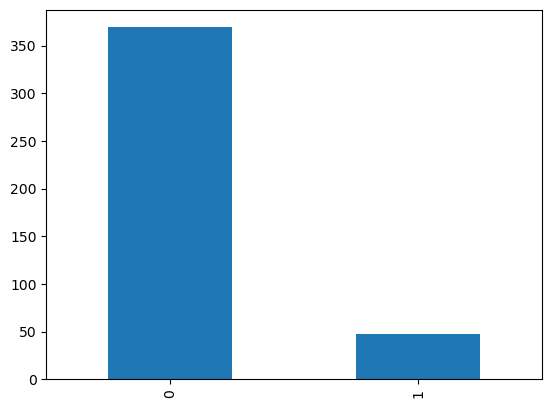

In [33]:
print(Final_Data["Anomaly"].value_counts())
Final_Data["Anomaly"].value_counts().plot.bar()

In [34]:
y = Final_Data["Anomaly"]
X = Final_Data.drop('Anomaly',axis=1)

over = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_un, y_un = pipeline.fit_resample(X, y)
#X_un, y_un = X, y
# scaling the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_un)


0    368
1    184
Name: Anomaly, dtype: int64


<AxesSubplot: >

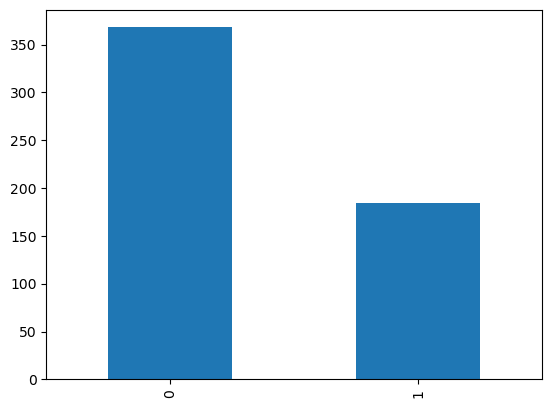

In [35]:
print(y_un.value_counts())
y_un.value_counts().plot.bar()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_un, test_size=0.3
)

X_train = pd.DataFrame(X_train, columns=X.columns) 
X_test = pd.DataFrame(X_test, columns=X.columns) 

X_train

,rdp_sch_shape_len,rdp_rt_shape_len,Hausdorff_Dist,Area_bt_Curves,Curve_length
0,0.0,1.133651,-0.461454,-0.191979,0.481334
1,0.0,1.873776,-0.461454,-0.793876,-0.737292
2,0.0,-1.456785,-0.298376,-0.109211,0.018552
3,0.0,-1.456785,-0.313015,-0.303541,-0.762221
4,0.0,-1.456785,4.426941,1.769962,2.133323
...,...,...,...,...,...
381,0.0,1.133651,-0.388802,-0.523347,-0.137068
382,0.0,-0.346598,-0.519503,-0.568668,-0.971815
383,0.0,-0.716661,-0.512813,-0.258553,-0.985179
384,0.0,2.613901,-0.463789,-0.781997,-0.831953


In [37]:

def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    
    
    #y_pred = model.predict(predictors)
    cm = confusion_matrix(target, pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    plt.show()
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    ### Compute ROC curve and ROC area for predictions on validation set
    fpr, tpr, _ = roc_curve(target, pred)
    roc_auc = auc(fpr, tpr)

    ### Plot
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,"AUC":roc_auc},
        index=[0],
    )

    return df_perf

<Figure size 600x400 with 0 Axes>

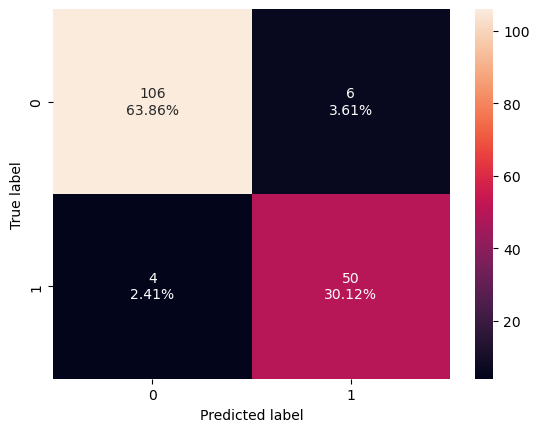

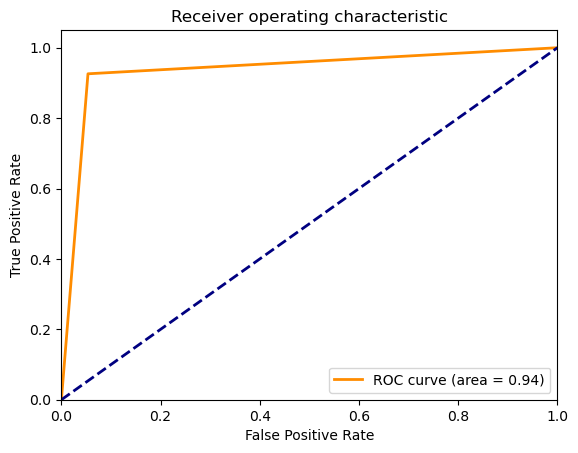

,Accuracy,Recall,Precision,F1,AUC
0,0.939759,0.925926,0.892857,0.909091,0.936177


In [38]:
model1 = KNeighborsClassifier(n_neighbors=5)

# train the model
model1.fit(X_train,y_train)

# check performance on train data
knn_test_perf = model_performance_classification_sklearn(
    model1, X_test, y_test
)  
knn_test_perf

<Figure size 600x400 with 0 Axes>

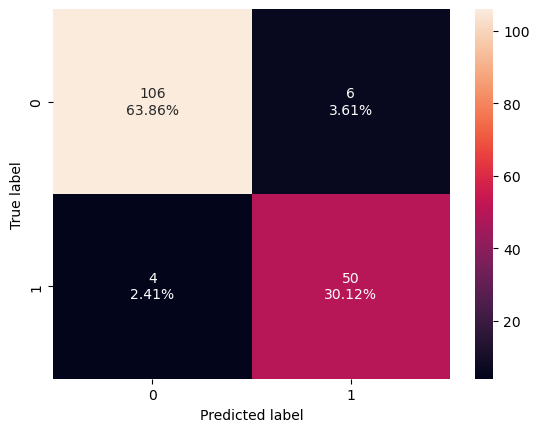

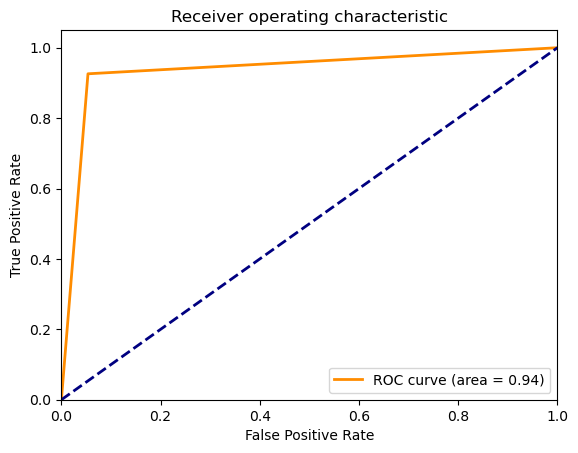

,Accuracy,Recall,Precision,F1,AUC
0,0.939759,0.925926,0.892857,0.909091,0.936177


In [39]:
# Choose the type of classifier.
knn_tuned = KNeighborsClassifier()

parameters = {
    "n_neighbors": [3,5,7,9,11],
    "algorithm" :['auto', 'ball_tree', 'kd_tree', 'brute'],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(
    knn_tuned, parameters,cv =5 ,n_jobs=-1
)  ## run grid search with cv = 5 and n_jobs = -1
grid_obj = grid_obj.fit(X_train, y_train)  ## fit the grid_obj on the train data

# Set the clf to the best combination of parameters
knn_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
knn_tuned.fit(X_train, y_train)

# check performance on train data
knn_tuned_test_perf = model_performance_classification_sklearn(
    knn_tuned, X_test, y_test
)  
knn_tuned_test_perf

<Figure size 600x400 with 0 Axes>

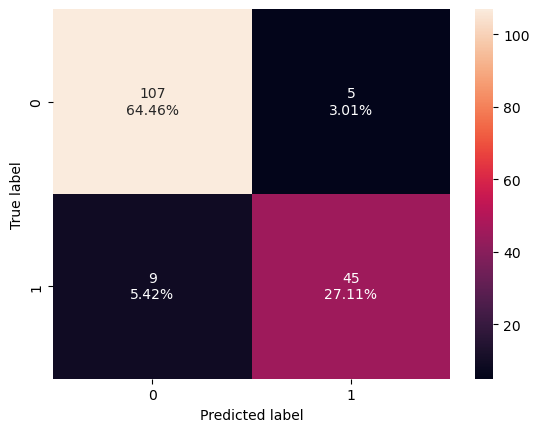

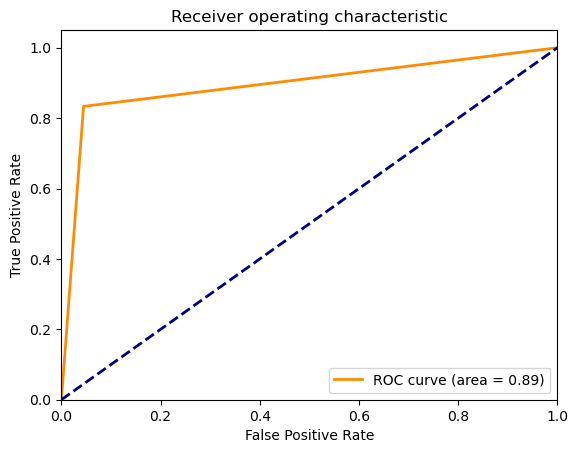

,Accuracy,Recall,Precision,F1,AUC
0,0.915663,0.833333,0.9,0.865385,0.894345


In [40]:
### Initialize the model  
model2 = LogisticRegression()

# train the model
model2.fit(X_train,y_train)

# check performance on train data
lr_test_perf = model_performance_classification_sklearn(
    model2, X_test, y_test
)  
lr_test_perf

<Figure size 600x400 with 0 Axes>

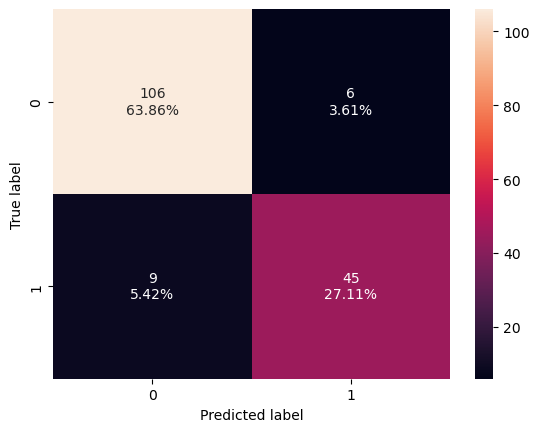

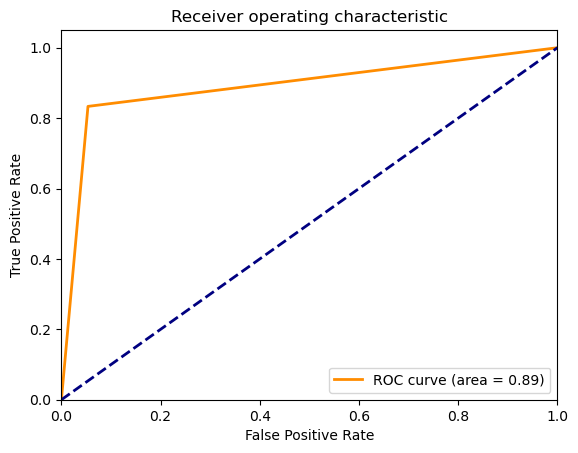

,Accuracy,Recall,Precision,F1,AUC
0,0.909639,0.833333,0.882353,0.857143,0.889881


In [41]:
# Choose the type of classifier.
lr_tuned = LogisticRegression()

parameters = {
    "penalty":['l1', 'l2', 'elasticnet'],
    "solver":['newton-cg', 'lbfgs', 'liblinear'],
    "C": [0.1, 0.5, 2, 3],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(
    lr_tuned, parameters, n_jobs=-1
)  ## run grid search with cv = 5 and n_jobs = -1
grid_obj = grid_obj.fit(X_train, y_train)  ## fit the grid_obj on the train data

# Set the clf to the best combination of parameters
lr_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
lr_tuned.fit(X_train, y_train)


# check performance on train data
lr_tuned_test_perf = model_performance_classification_sklearn(
    lr_tuned, X_test, y_test
)  
lr_tuned_test_perf

<Figure size 600x400 with 0 Axes>

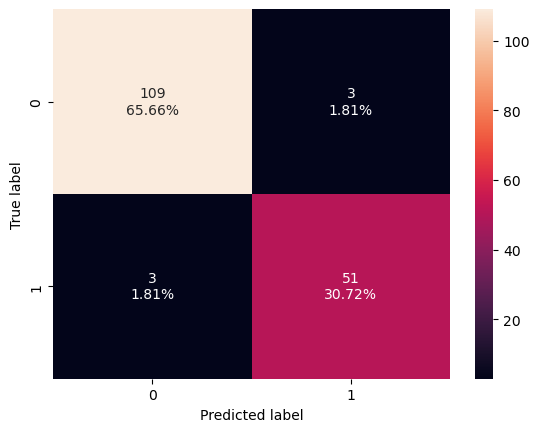

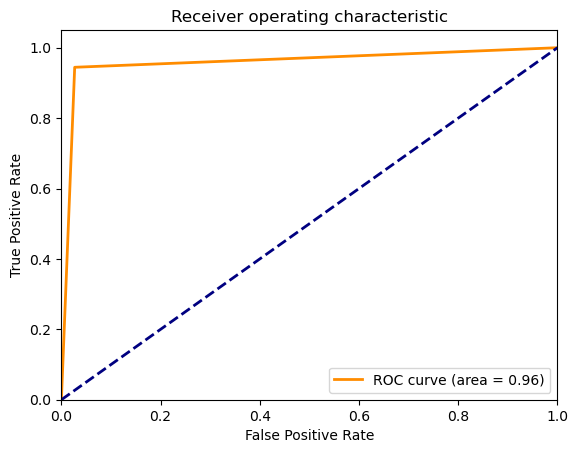

,Accuracy,Recall,Precision,F1,AUC
0,0.963855,0.944444,0.944444,0.944444,0.958829


In [42]:
### Initialize the model  
model3 = RandomForestClassifier(random_state=42)

# train the model
model3.fit(X_train,y_train)

# check performance on train data
rf_test_perf = model_performance_classification_sklearn(
    model3, X_test, y_test
)  
rf_test_perf

Chosen best 7 feature by rfe: Index(['rdp_sch_shape_len', 'rdp_rt_shape_len', 'Hausdorff_Dist',
       'Area_bt_Curves', 'Curve_length'],
      dtype='object')


<Figure size 600x400 with 0 Axes>

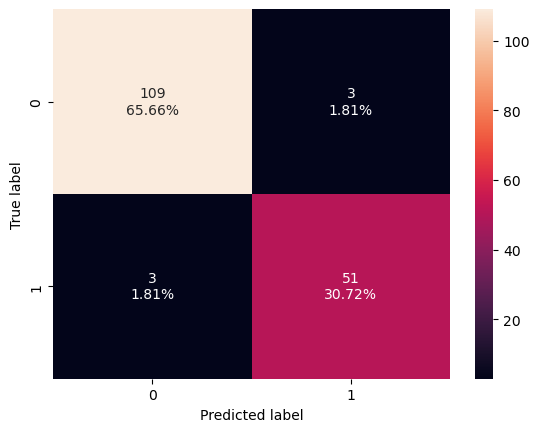

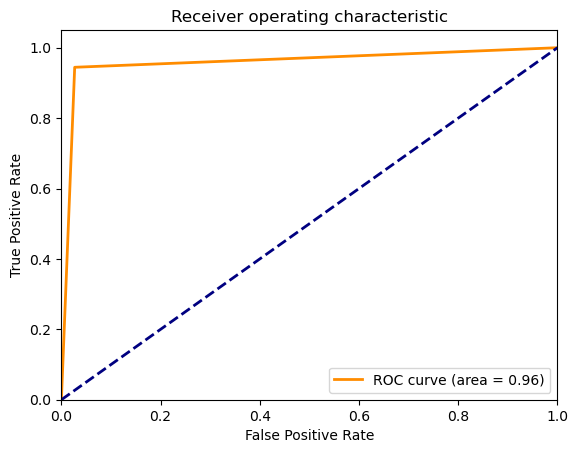

,Accuracy,Recall,Precision,F1,AUC
0,0.963855,0.944444,0.944444,0.944444,0.958829


In [43]:
### Initialize the model  
model4 = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=model4, n_features_to_select=7, step=1)
rfe = rfe.fit(X_train, y_train)
print('Chosen best 7 feature by rfe:',X.columns[rfe.support_])

# train the model
model4.fit(X_train[X.columns[rfe.support_]],y_train)

# check performance on train data
rf_new_test_perf = model_performance_classification_sklearn(
    model4, X_test[X.columns[rfe.support_]], y_test
)  
rf_new_test_perf

<Figure size 600x400 with 0 Axes>

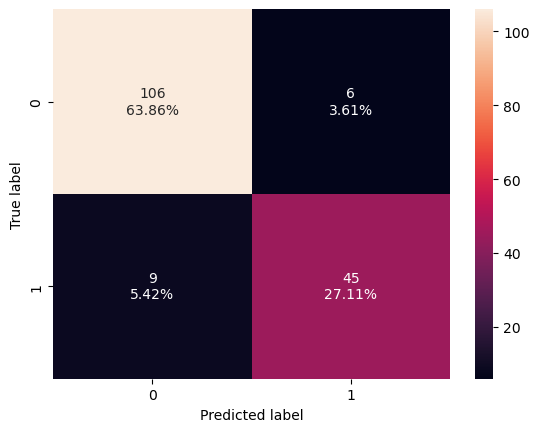

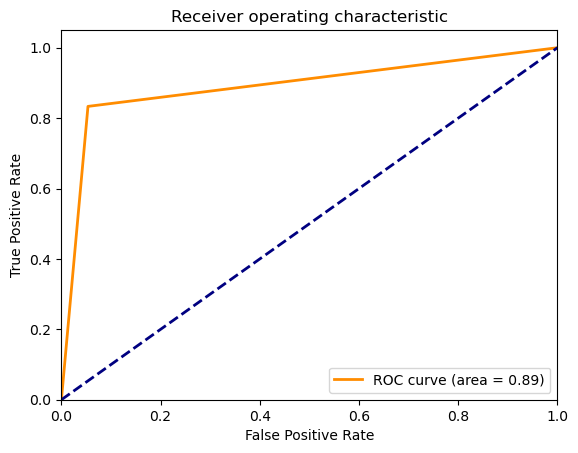

,Accuracy,Recall,Precision,F1,AUC
0,0.909639,0.833333,0.882353,0.857143,0.889881


In [44]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

parameters = {
    "max_depth": list(np.arange(5, 15, 5)),
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [5, 7],
    "n_estimators": [50,100,200,300,400],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(
    rf_tuned, parameters, n_jobs=-1
)  ## run grid search with cv = 5 and n_jobs = -1
grid_obj = grid_obj.fit(X_train, y_train)  ## fit the grid_obj on the train data

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train, y_train)

# check performance on train data
rf_tuned_test_perf = model_performance_classification_sklearn(
    lr_tuned, X_test, y_test
)  
rf_tuned_test_perf

<Figure size 600x400 with 0 Axes>

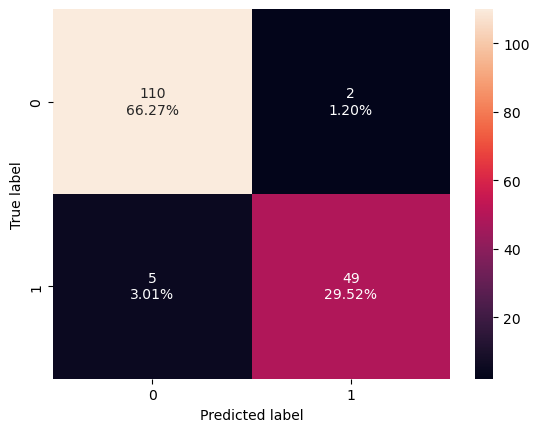

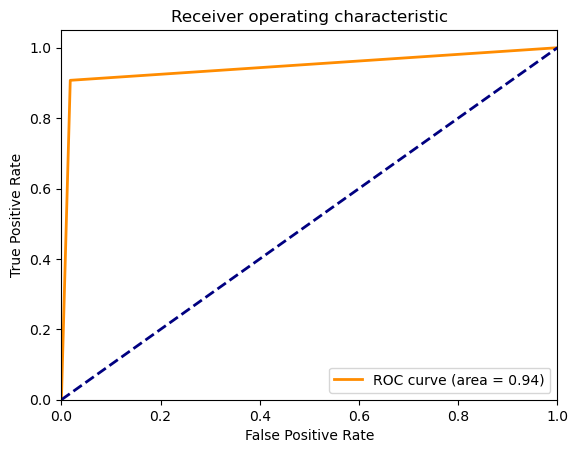

,Accuracy,Recall,Precision,F1,AUC
0,0.957831,0.907407,0.960784,0.933333,0.944775


In [45]:
### Initialize the model  
model4 = DecisionTreeClassifier()

# train the model
model4.fit(X_train,y_train)

# check performance on train data
dt_test_perf = model_performance_classification_sklearn(
    model4, X_test, y_test
)  
dt_test_perf

<Figure size 600x400 with 0 Axes>

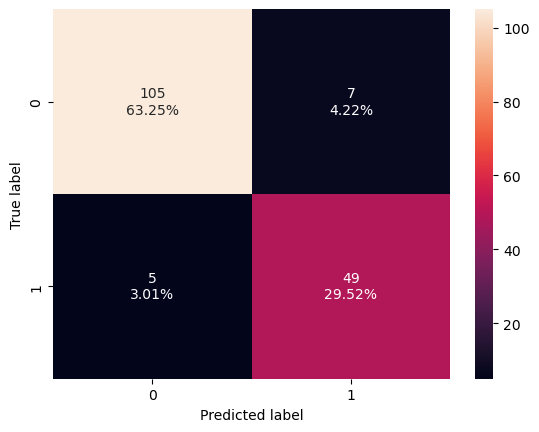

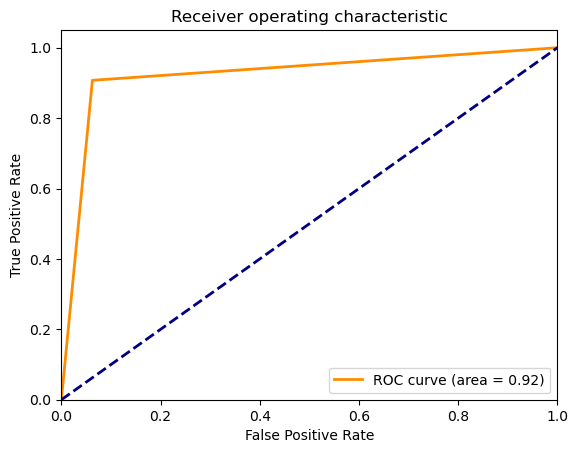

,Accuracy,Recall,Precision,F1,AUC
0,0.927711,0.907407,0.875,0.890909,0.922454


In [46]:
from sklearn import svm
model5 = svm.SVC()

model5.fit(X_train,y_train)

# check performance on train data
svm_test_perf = model_performance_classification_sklearn(
    model5, X_test, y_test
)  
svm_test_perf

<Figure size 600x400 with 0 Axes>

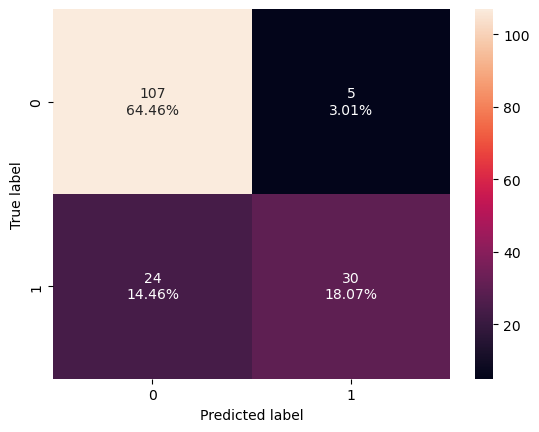

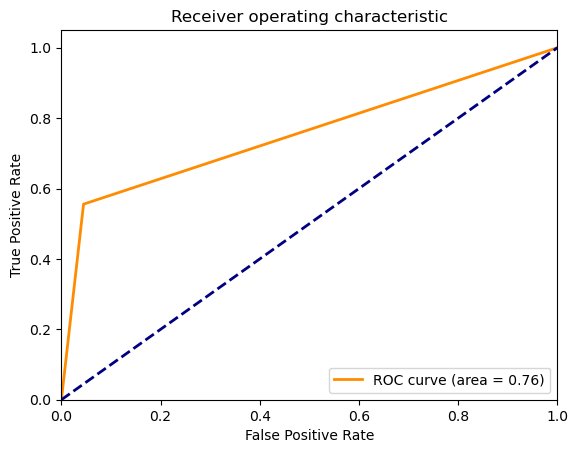

,Accuracy,Recall,Precision,F1,AUC
0,0.825301,0.555556,0.857143,0.674157,0.755456


In [47]:
from sklearn.naive_bayes import GaussianNB
model6 = GaussianNB()

model6.fit(X_train,y_train)

# check performance on train data
nb_test_perf = model_performance_classification_sklearn(
    model6, X_test, y_test
)  
nb_test_perf

<Figure size 600x400 with 0 Axes>

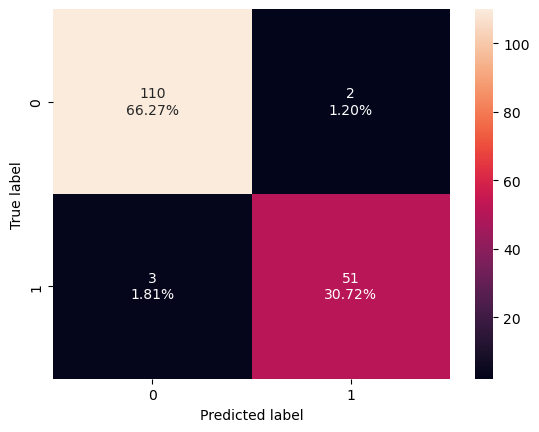

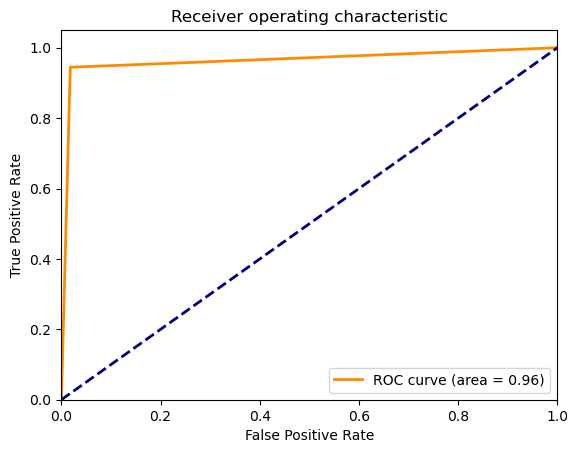

,Accuracy,Recall,Precision,F1,AUC
0,0.96988,0.944444,0.962264,0.953271,0.963294


In [49]:
from xgboost import XGBClassifier

model7 = XGBClassifier()

model7.fit(X_train,y_train)

# check performance on train data
nb_test_perf = model_performance_classification_sklearn(
    model7, X_test, y_test
)  
nb_test_perf

In [48]:
# training performance comparison

models_train_comp_df = pd.concat(
    [knn_test_perf.T,knn_tuned_test_perf.T,lr_test_perf.T,lr_tuned_test_perf.T,rf_test_perf.T,rf_new_test_perf.T,rf_tuned_test_perf.T,
     dt_test_perf.T, svm_test_perf.T, nb_test_perf.T], axis=1,
)
models_train_comp_df.columns = [
    "KNN ",
    "Tuned KNN ",
    "Logistic Regression",
    "Tuned Logistic Regression",
    "Random Forest ",
    "Random Forest with Feature Selection",
    "Tuned Random Forest ",
    "Decision Tree",
    "SVM",
    "Naive Bayes"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,KNN,Tuned KNN,Logistic Regression,Tuned Logistic Regression,Random Forest,Random Forest with Feature Selection,Tuned Random Forest,Decision Tree,SVM,Naive Bayes
Accuracy,0.939759,0.939759,0.915663,0.909639,0.963855,0.963855,0.909639,0.957831,0.927711,0.825301
Recall,0.925926,0.925926,0.833333,0.833333,0.944444,0.944444,0.833333,0.907407,0.907407,0.555556
Precision,0.892857,0.892857,0.900000,0.882353,0.944444,0.944444,0.882353,0.960784,0.875000,0.857143
F1,0.909091,0.909091,0.865385,0.857143,0.944444,0.944444,0.857143,0.933333,0.890909,0.674157
AUC,0.936177,0.936177,0.894345,0.889881,0.958829,0.958829,0.889881,0.944775,0.922454,0.755456
